<IPython.core.display.Javascript object>


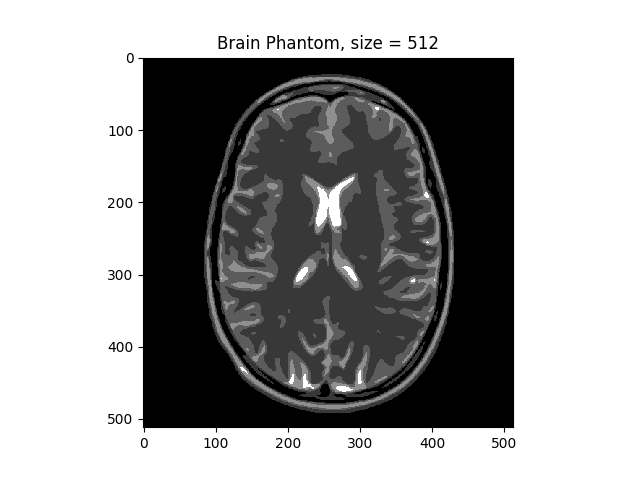

In [3]:
#DISPLAY BRAIN PHANTOM
%matplotlib nbagg

import numpy as np
import os.path as op
import os
import math ; import cmath
import matplotlib.pyplot as plt
import sys

from skimage import data, img_as_float, io, filters
from skimage.measure import compare_ssim as ssim

#get current working dir

cwd = os.getcwd()
dirimg_2d = op.join(cwd,"data")
img_size = 512   #256
FOV = 0.2 #field of view parameter in m (ie real FOV = 20 x20 cm^2)
pixelSize = FOV/img_size

#load data file corresponding to the target resolution
filename = "BrainPhantom" + str(img_size) + ".png"
mri_filename = op.join(dirimg_2d, filename)
mri_img = io.imread(mri_filename, as_gray=True)
plt.figure()
plt.title("Brain Phantom, size = "+ str(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

In [23]:
#PARAMETERS AND CONSTRAINTS
from collections import namedtuple

samplingOptions = namedtuple("samplingOptions", "nc ns OS_factor decim tau decay mask iter init Kmax Smax Gmax gamma dTime n_revol n_epi")




#Kmax depends of FOV and image resolution (NS criterion)
#Gmax and Smax : maximum gradient (T/m) and slew rate (T/m/ms)
#tau, decay and mask parametrize the sampling density (mask=1 for circular - isotrope kspace - 0 otherwise)
#iter = number of iterations (gradient descent steps?)
#mask = initialization for SPARKLING (radial in-out, radial center-out, spiral in-out...)
#gamma = gyromagnetic constant (Hz/T)

samplingOptions.nc = 70 #nc is the number of shots in the k-space
samplingOptions.ns = 3073 #ns is the number of gradient samples per shot
samplingOptions.OS_factor = 1 #Oversampling factor = (gradient raster time)/(gradient dwell time)
samplingOptions.decim = 8 # decimation factor 

samplingOptions.decay = 2. # decay of the target radial sampling density
samplingOptions.tau = 0.75 # threshold for setting the plateau around k=0: 1/(nb per sample/k-space pixel)

samplingOptions.init = "Cartesian"  # definie the shape of the initial trajectory
samplingOptions.mask = 1            # 1=isotropic, 0=square
samplingOptions.iter = 300          # nb of iterations in the optim algorithm for Sparkling

samplingOptions.Kmax = img_size/(2*FOV) # Max sampling frequency in m^{-1}: same along k_x, k_y
samplingOptions.Gmax = 40e-3            # hardware constraint on Gmax (gradient magnitude) in mT/m
samplingOptions.Smax = 200e-3           # hardware constraint on Smax (slew rate) in mT/m/ms

samplingOptions.gamma = 42.576e3 ; samplingOptions.dTime = 0.010 #in ms

samplingOptions.n_revol = 1


In [24]:

#CALCULATED VALUES

alpha = samplingOptions.gamma * samplingOptions.Gmax
beta = samplingOptions.gamma * samplingOptions.Smax

cst_ = 1./(2*np.pi)
alpha_R = alpha/samplingOptions.Kmax * cst_
beta_R = beta/samplingOptions.Kmax * cst_

ns_shot  = 2*math.floor(samplingOptions.ns/2)+1 #odd number of samples for decimation

ns_shot_decim = math.ceil(ns_shot/samplingOptions.decim) #number of shots per decimation step

print("ns_shot_decim = " + str(ns_shot_decim))

Dk0_R = 2*pixelSize/FOV*1/(2*np.pi) #divide by Kmax*2pi

eps = sys.float_info.epsilon
#print("epsilon = " + str(eps))

#Criterium (iii), eq (3.4) C.Lazarus PhD thesis
alpha_R = min( Dk0_R/(samplingOptions.dTime * samplingOptions.OS_factor), alpha_R)

#UNDERSAMPLING FACTOR
#UF = np.power(img_size,2)/(samplingOptions.nc*samplingOptions.ns) #R in C.Lazarus phd 3.3.2
us_fct = img_size**2/(samplingOptions.nc * samplingOptions.ns) #R in C.Lazarus phd 3.3.2

#ACCELERATION RATA
#AF = img_size/samplingOptions.nc
accel_fct = img_size/samplingOptions.nc

print("Undersampling factor = %d " %  us_fct)
print("Acceleration factor = %d" % accel_fct)


ns_shot_decim = 385
Undersampling factor = 1 
Acceleration factor = 7


In [25]:
print("Initialization for Spiral In-Out")
        
ns_shot_decim_sym = (ns_shot_decim - 1)/2
k_TE = math.ceil(samplingOptions.ns/2) #echo time
k_TE_decim = math.ceil(k_TE/samplingOptions.decim)

#Intermediate calculations: normalized positions in k-space
ic1 = np.arange(0,ns_shot_decim_sym+1, dtype = np.complex_)/ns_shot_decim_sym * cst_ * (1-eps)
ic2 = np.exp(2*1j*np.pi*np.arange(0,ns_shot_decim_sym+1, dtype=np.complex_)
             /ns_shot_decim_sym*samplingOptions.n_revol)

s00_c1 = np.multiply(ic1, ic2)
s00_c2 = -s00_c1[1:]
s00_c= np.append(np.flip(s00_c1, axis = 0),s00_c2)
        
shot = np.array([], dtype = np.complex_) 
# aggregate shots        
for l in np.arange(0,samplingOptions.nc):
    shot = np.append(shot, s00_c * np.exp(1j*2*np.pi*l/(samplingOptions.nc*2)))
            

Initialization for Spiral In-Out


<IPython.core.display.Javascript object>


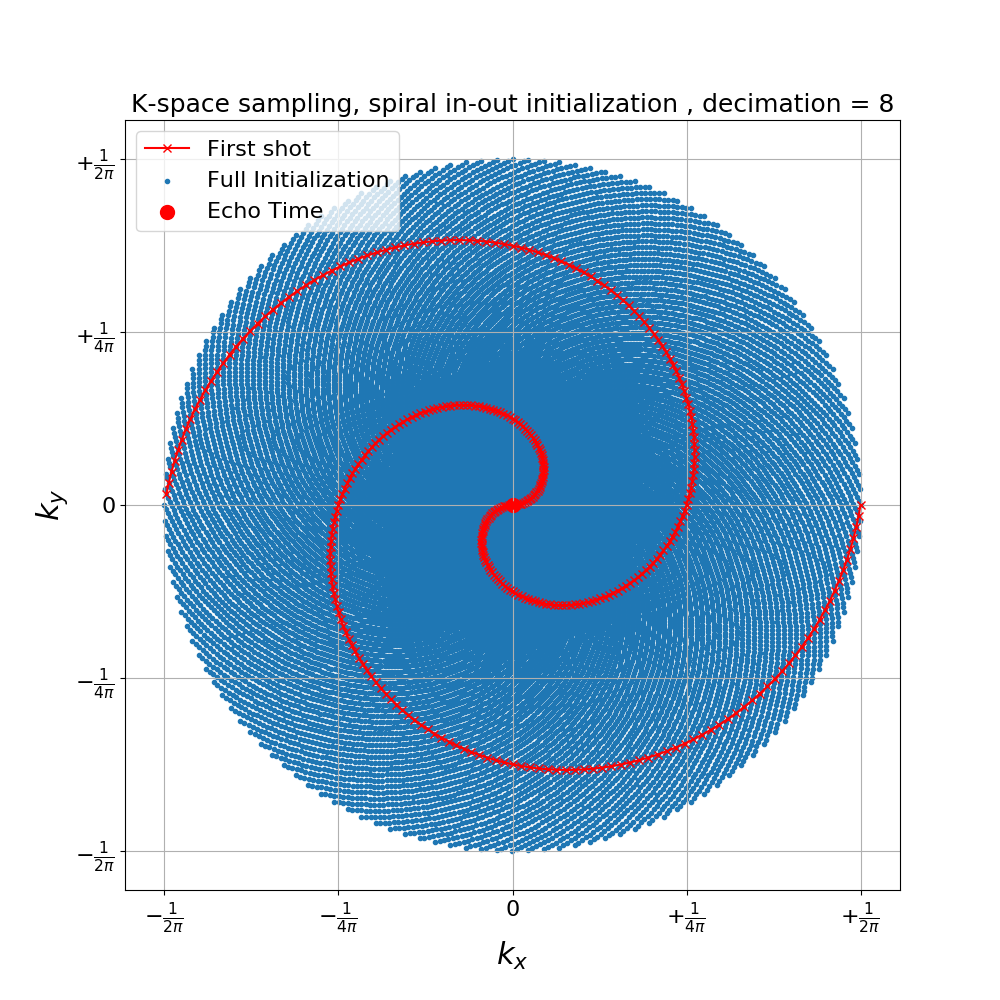

In [26]:
## PLOT SAMPLING SCHEME

k_vec = np.zeros((len(shot),2))
k_vec[:,0] = shot.real  # real coordinates along the first col
k_vec[:,1] = shot.imag  # imaginary coordinates along the second col

#Plot full initialization
kspace = plt.figure(figsize = (10,10))
plt.scatter(k_vec[:,0],k_vec[:,1], marker = '.', label = "Full Initialization")
axes = plt.gca() 
plt.grid()

#Display first shot
plt.plot(k_vec[0:ns_shot_decim-1,0],k_vec[0:ns_shot_decim-1,1], color='r', marker = 'x'
         , label = "First shot")

#Sample at echo time
plt.scatter(k_vec[k_TE_decim-1,0], k_vec[k_TE_decim-1,1], marker = 'o', color='r', s=100,
            label = "Echo Time")

#Figure layout
unit = 1/4 ; tick = np.arange(-0.5, 0.5 + unit, unit)
label = [r"$-\frac{1}{2\pi}$", r"$-\frac{1}{4\pi}$", r"$0$", r"$+\frac{1}{4\pi}$",  r"$+\frac{1}{2\pi}$"]
plt.xticks(tick/np.pi,labels = label, fontsize = 16) ; plt.yticks(tick/np.pi,labels = label, fontsize = 16)
plt.xlabel(r"$k_x$", fontsize = 22) ; plt.ylabel(r"$k_y$", fontsize = 22)
plt.title("K-space sampling, spiral in-out initialization , decimation = " 
          + str(samplingOptions.decim),fontsize = 18)
plt.legend(fontsize = 16)

plt.show()

setting image dimension Nd... (512, 512)
setting spectrum dimension Kd... (512, 512)
setting interpolation size Jd... (6, 6)
setting non-uniform data
y is an (M,) list <class 'numpy.ndarray'> (26950,)


<IPython.core.display.Javascript object>


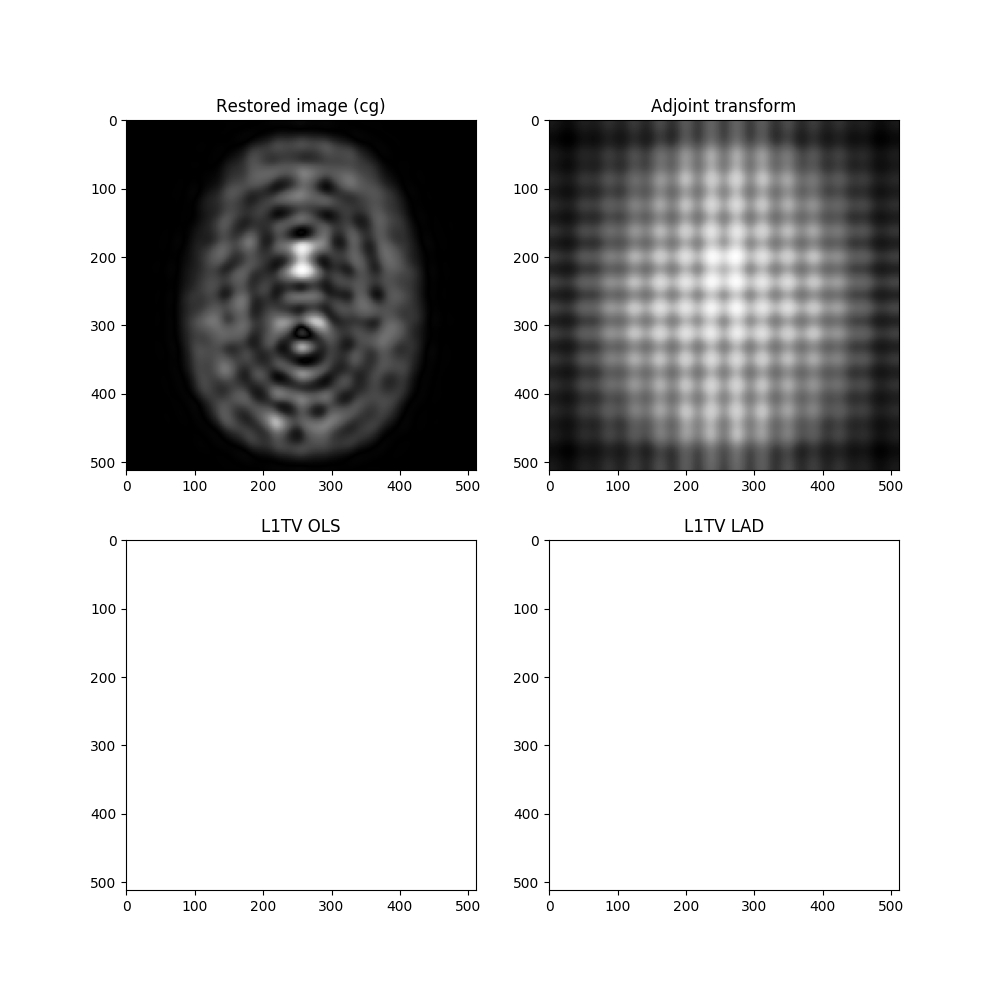

In [31]:
#from pynfft.nfft import NFFT
import scipy.misc
import matplotlib.pyplot 
from pynufft import NUFFT_cpu

# print(k_vec.shape)
# print(type(k_vec.shape))
# a = k_vec.shape[0]
# print(a)
# plan = NFFT([img_size, img_size], k_vec.shape[0])
# plan.precompute()
NufftObj = NUFFT_cpu()
Nd = (img_size, img_size)  # image size
print('setting image dimension Nd...', Nd)
Kd = (img_size, img_size)  # k-space size
print('setting spectrum dimension Kd...', Kd)
Jd = (6, 6)  # interpolation size
print('setting interpolation size Jd...', Jd)

NufftObj.plan(k_vec, Nd, Kd, Jd)

kspace_data = NufftObj.forward(mri_img)
print('setting non-uniform data')
print('y is an (M,) list',type(kspace_data), kspace_data.shape)

compute_sol = 1
# various image reconstruction algos embedded in pynufft
if compute_sol:
    img_rec0 = NufftObj.solve(kspace_data, solver='cg',maxiter=1e2)
    img_rec1 = NufftObj.adjoint(kspace_data)
    img_rec2 = NufftObj.solve(kspace_data, solver='L1TVOLS',maxiter=1e2,rho=1e-3)
    img_rec3 = NufftObj.solve(kspace_data, solver='L1TVLAD',maxiter=1e2,rho=1e-3)

fig, axs = plt.subplots(2, 2, figsize=(10, 10) )
axs[0,0].imshow(np.abs(img_rec0), cmap='Greys_r')#, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1)
#axs[0,0].imshow(img_rec0.real, cmap='Greys_r', norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))
axs[0,0].set_title("Restored image (cg)")

axs[0,1].imshow(np.abs(img_rec1), cmap='Greys_r') #, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=5))
#axs[0,1].imshow(img_rec1.real, cmap='Greys_r', norm=matplotlib.colors.Normalize(vmin=0.0, vmax=5))
axs[0,1].set_title("Adjoint transform")

axs[1,0].imshow(np.abs(img_rec2), cmap='Greys_r') #, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))
#axs[1,0].imshow(img_rec2.real, cmap='Greys_r', norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))
axs[1,0].set_title("L1TV OLS")

axs[1,1].imshow(np.abs(img_rec3), cmap='Greys_r') #, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))
#axs[1,1].imshow(img_rec3.real, cmap='Greys_r', norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))
axs[1,1].set_title("L1TV LAD")

plt.show()


In [12]:
print(k_vec.shape)


(1715, 2)
